In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
import random
from Bio import SeqIO

if os.path.split(os.getcwd())[-1]=='Scripts':
    os.chdir(os.path.split(os.getcwd())[0])
from Scripts.tam_generation import set_up_toy_tam, set_up_ecolicore_tam
from Scripts.ecolicore_tam_incl_transcript_info import get_transcript_data

TRANSCRIPT_FILE_PATH = os.path.join('Data', 'TAModel', 'Sinha-etal_2021_transcript-data.xlsx')

Loading PAModelpy modules version 0.0.3.4
Loading PAModelpy modules version 0.0.3.3


In [2]:
#get FVA results
ecolicore_tam = set_up_ecolicore_tam()
result = pd.read_excel('Results/fva_transcripts.xlsx',index_col=0)#.reset_index(inplace=True)
result = result.reset_index()
result['index'] = result['index'].apply(lambda x: x.split('_')[1:])

Set parameter Username
Academic license - for non-commercial use only - expires 2025-03-06
No enzyme information found for reaction: D_LACt2
No enzyme information found for reaction: FRD7
No enzyme information found for reaction: LDH_D
Read LP format model from file /tmp/tmps1evjhxk.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros
Setting up the proteome allocation model e_coli_core

Add total condition-dependent protein constraint
	Total protein concentration: 0.185 g/gDW

Add active protein sector

Add the following protein sector: TranslationalProteinSector

Add the following protein sector: UnusedEnzymeSector

Done with setting up the proteome allocation model e_coli_core

Setting up the transcript allocation model,  None
Add the following mRNA sector:  ActivemRNASector 



/home/samiralvdb/Documents/3_Projects/7_MCA_analysis/PAModelpy/src/PAModelpy/PAModel.py:222: UserWarning: Molar mass for E429 is invalid: 0.0
  warnings.warn(f'Molar mass for {enz.id} is invalid: {molmass}')
/home/samiralvdb/Documents/3_Projects/7_MCA_analysis/PAModelpy/src/PAModelpy/PAModel.py:262: UserWarning: FORt: Inconsistencies between the reaction reversibility and the provided kcat values
  warnings.warn(rxn_id+': Inconsistencies between the reaction reversibility and the provided kcat values')


# 1. Compare FVA results with measured data

In [3]:
transcript_data = get_transcript_data()

In [4]:
#compare FVA results with measured values: are the measured values in line with the model flexibility
result_dict = {}
for index, row in result.iterrows():
    genes = row['index']
    min_val = row['minimum']
    max_val = row['maximum']
    for gene in genes:
        transcript_values = []
        if gene in transcript_data.index:
            transcript_values.append(transcript_data.loc[gene].REF)
    if len(transcript_values)>0:
        ref_val = np.min(transcript_values)
        result_dict['_'.join(genes)] = [min_val <= ref_val*1e-6 <= max_val, min_val, ref_val, max_val]

result_df = pd.DataFrame.from_dict(result_dict, orient='index', columns=['isinrange', 'min', 'reference', 'max'])
result_df

,isinrange,min,reference,max
b0720,False,1.341553e-11,1.057477e-07,6.987255e-10
b3403,False,0.000000e+00,1.126019e-07,0.000000e+00
b1479,False,0.000000e+00,9.608811e-08,0.000000e+00
b3925,False,0.000000e+00,9.675921e-08,0.000000e+00
b4232,False,0.000000e+00,9.676092e-08,0.000000e+00
...,...,...,...,...
b2284,True,0.000000e+00,1.062763e-07,3.009661e-01
b2282,True,0.000000e+00,1.106636e-07,4.118645e-01
b2286,True,0.000000e+00,1.261362e-07,2.247998e-01
b2987,False,1.412476e-10,5.725252e-08,7.356647e-09


# 2. Check COG over/underrepresentation in predictions

In [5]:
# check some statistics related to function (and probably to translation mechanism?)
genome_information = pd.read_excel(os.path.join('Data', 'TAModel','GeneList_ecoli.xlsx'),
                                sheet_name='GeneList').set_index('bnumber')
fva_results_with_info = result_df.merge(genome_information[['COG', 'COG description','gene_name']], left_index = True, right_index=True, how = 'left')
fva_results_cog = fva_results_with_info.assign(
    COG_description= fva_results_with_info['COG description'].str.split(';')).explode('COG_description').reset_index(drop=True)

In [6]:
print('Number of feasible to simulate mrnas: ', sum(fva_results_with_info.isinrange))
print('Number of infeasible to simulate mrnas: ', len(fva_results_with_info) - sum(fva_results_with_info.isinrange))

Number of feasible to simulate mrnas:  49
Number of infeasible to simulate mrnas:  32


(-1.122838773766519,
 1.1134960809714323,
 -1.106367185651268,
 1.1125499340272793)

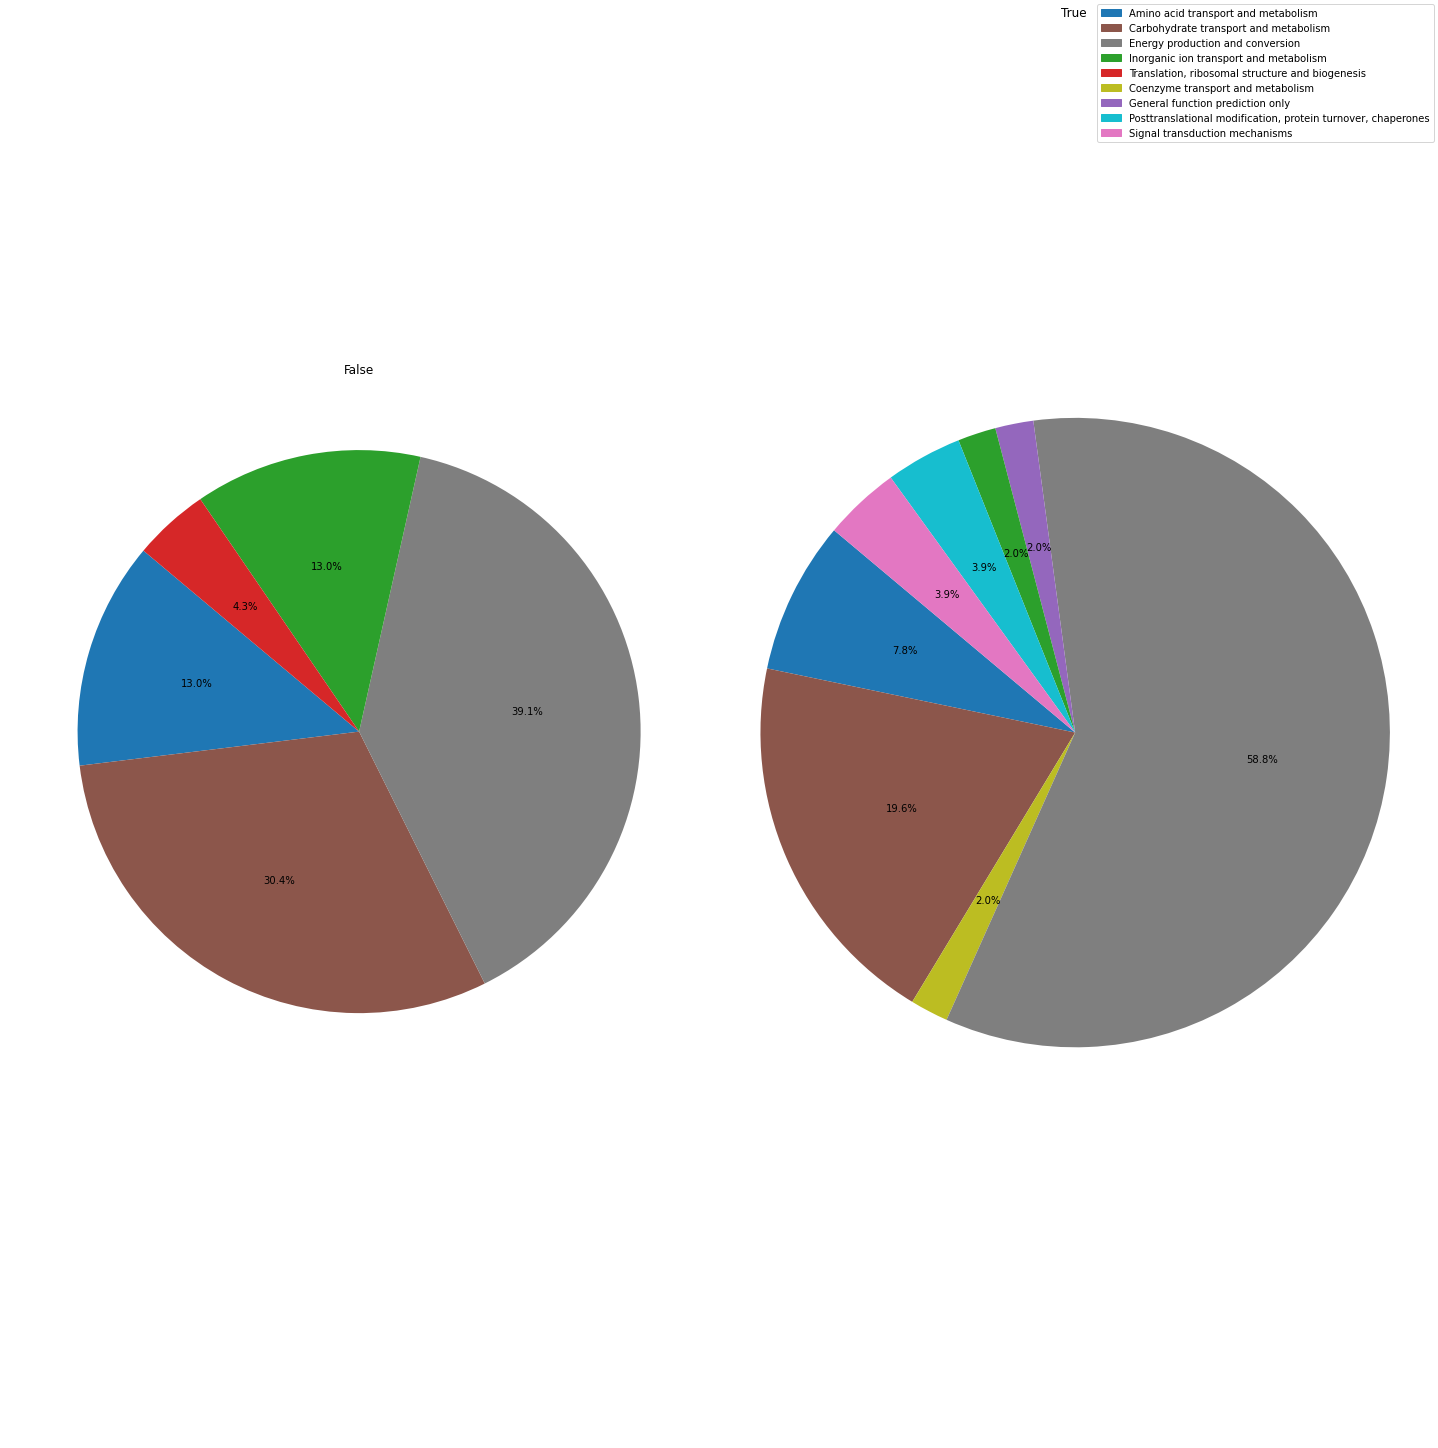

In [7]:
inrange_transcript_info = fva_results_cog.groupby('isinrange', as_index=False)

fig, axs = plt.subplots(ncols = 2, figsize = (20,20))
i=0
colors = plt.cm.tab10.colors  # Choose a colormap, e.g., tab10

# Dictionary to store COG descriptions and corresponding colors
cog_colors = {}

for inrange, transcript_data in inrange_transcript_info:
    # Extracting data for the pie chart
    sizes = transcript_data.groupby('COG_description').count().div(len(transcript_data)).reference
    labels = list(sizes.index)
    
    # Assigning colors to COG descriptions
    for label in labels:
        if not label in cog_colors.keys():
            color = random.sample(colors, 1)
            # Remove sampled colors from the original set of colors
            colors = [c for c in colors if c not in color]
            cog_colors[label] = color[0]
    
    # Creating the pie chart
    axs[i].pie(sizes, colors=[cog_colors[label] for label in labels],
               autopct='%1.1f%%', startangle=140)
    axs[i].set_title(inrange)
    i+=1
    
# Creating a legend for COG descriptions and colors
handles = [plt.Rectangle((0,0),1,1, color=cog_colors[label]) for label in cog_colors]
labels = list(cog_colors.keys())
fig.legend(handles, labels, loc='upper right')

plt.tight_layout()
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Check some statistics

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

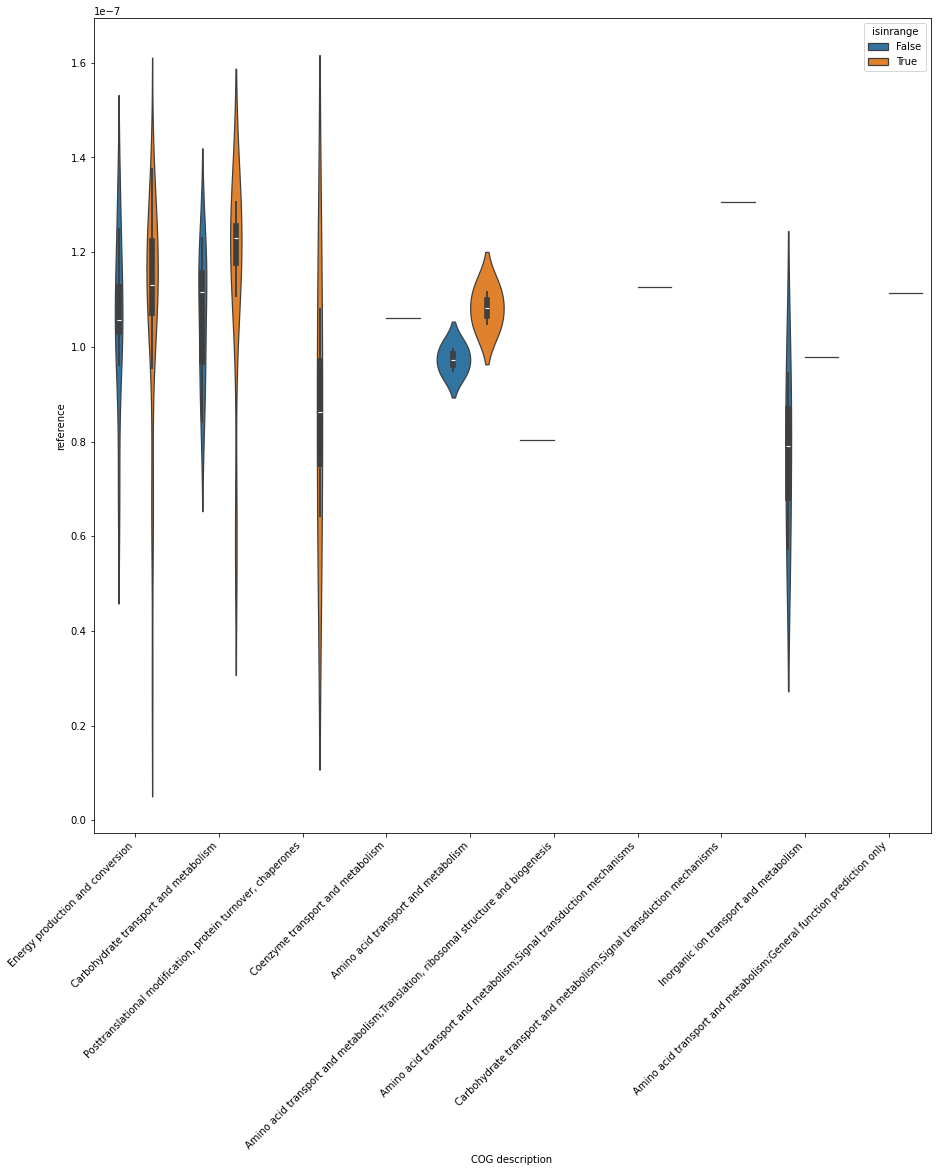

In [8]:
fig, ax = plt.subplots(figsize= (15,15))
sns.violinplot(fva_results_with_info, x='COG description', y = 'reference', hue = 'isinrange')
plt.xticks(rotation=45, ha='right')

# 3. Check sequence features

In [41]:
# first get the protein sequence information from the ecoli fasta file
protein_sequences = {}

# Parse the FASTA file
for record in SeqIO.parse('Data/24_04_16_UP000000625_Ecoli_K12.fasta', "fasta"):
    # Extract gene name from the record's description
    index_of_gn = record.description.find("GN=")

    # Extract the substring after "GN="
    if index_of_gn != -1:
        gene_name = record.description[index_of_gn + len("GN="):].split()[0]
    
        # Get the protein sequence
        protein_sequences[gene_name] = str(record.seq)
print(protein_sequences)

{'mgtS': 'MLGNMNVFMAVLGIILFSGFLAAYFSHKWDD', 'thiS': 'MQILFNDQAMQCAAGQTVHELLEQLDQRQAGAALAINQQIVPREQWAQHIVQDGDQILLFQVIAGG', 'gnd': 'MSKQQIGVVGMAVMGRNLALNIESRGYTVSIFNRSREKTEEVIAENPGKKLVPYYTVKEFVESLETPRRILLMVKAGAGTDAAIDSLKPYLDKGDIIIDGGNTFFQDTIRRNRELSAEGFNFIGTGVSGGEEGALKGPSIMPGGQKEAYELVAPILTKIAAVAEDGEPCVTYIGADGAGHYVKMVHNGIEYGDMQLIAEAYSLLKGGLNLTNEELAQTFTEWNNGELSSYLIDITKDIFTKKDEDGNYLVDVILDEAANKGTGKWTSQSALDLGEPLSLITESVFARYISSLKDQRVAASKVLSGPQAQPAGDKAEFIEKVRRALYLGKIVSYAQGFSQLRAASEEYNWDLNYGEIAKIFRAGCIIRAQFLQKITDAYAENPQIANLLLAPYFKQIADDYQQALRDVVAYAVQNGIPVPTFSAAVAYYDSYRAAVLPANLIQAQRDYFGAHTYKRIDKEGVFHTEWLD', 'frdA': 'MQTFQADLAIVGAGGAGLRAAIAAAQANPNAKIALISKVYPMRSHTVAAEGGSAAVAQDHDSFEYHFHDTVAGGDWLCEQDVVDYFVHHCPTEMTQLELWGCPWSRRPDGSVNVRRFGGMKIERTWFAADKTGFHMLHTLFQTSLQFPQIQRFDEHFVLDILVDDGHVRGLVAMNMMEGTLVQIRANAVVMATGGAGRVYRYNTNGGIVTGDGMGMALSHGVPLRDMEFVQYHPTGLPGSGILMTEGCRGEGGILVNKNGYRYLQDYGMGPETPLGEPKNKYMELGPRDKVSQAFWHEWRKGNTISTPRGDVVYLDLRHLGEKKLHERLPFICELAKAYVGVDPVKEPIPVRPTAHYTMGGIETDQNCETRIKGLFAVGECSSVGLHGAN

In [47]:
fva_results_with_sequence['sequence'] = np.NaN
for i, row in fva_results_with_sequence.iterrows():
    if row.gene_name in protein_sequences.keys(): 
        row.sequence = protein_sequences[row.gene_name]
        fva_results_with_sequence.loc[i] = row
fva_results_with_sequence

,isinrange,min,reference,max,COG,COG description,gene_name,sequence
b0720,False,1.341553e-11,1.057477e-07,6.987255e-10,C,Energy production and conversion,gltA,MADTKAKLTLNGDTAVELDVLKGTLGQDVIDIRTLGSKGVFTFDPG...
b3403,False,0.000000e+00,1.126019e-07,0.000000e+00,C,Energy production and conversion,pck,NaN
b1479,False,0.000000e+00,9.608811e-08,0.000000e+00,C,Energy production and conversion,maeA,MEPKTKKQRSLYIPYAGPVLLEFPLLNKGSAFSMEERRNFNLLGLL...
b3925,False,0.000000e+00,9.675921e-08,0.000000e+00,G,Carbohydrate transport and metabolism,glpX,MRRELAIEFSRVTESAALAGYKWLGRGDKNTADGAAVNAMRIMLNQ...
b4232,False,0.000000e+00,9.676092e-08,0.000000e+00,G,Carbohydrate transport and metabolism,fbp,MKTLGEFIVEKQHEFSHATGELTALLSAIKLGAKIIHRDINKAGLV...
...,...,...,...,...,...,...,...,...
b2284,True,0.000000e+00,1.062763e-07,3.009661e-01,C,Energy production and conversion,nuoF,MKNIIRTPETHPLTWRLRDDKQPVWLDEYRSKNGYEGARKALTGLS...
b2282,True,0.000000e+00,1.106636e-07,4.118645e-01,C,Energy production and conversion,nuoH,MSWISPELIEILLTILKAVVILLVVVTCGAFMSFGERRLLGLFQNR...
b2286,True,0.000000e+00,1.261362e-07,2.247998e-01,C,Energy production and conversion,nuoC,MTDLTAQEPAWQTRDHLDDPVIGELRNRFGPDAFTVQATRTGVPVV...
b2987,False,1.412476e-10,5.725252e-08,7.356647e-09,P,Inorganic ion transport and metabolism,pitB,MLNLFVGLDIYTGLLLLLALAFVLFYEAINGFHDTANAVAAVIYTR...


In [50]:
def summarize_sequence_features(sequences):
    all_sequences = ''.join(sequences.dropna().to_list()) 
    seq_composition = {}
    for aa in all_sequences:
        if aa not in seq_composition.keys(): seq_composition[aa] = 1
        else: seq_composition[aa] += 1
    
    seq_composition = {aa: nmbr/len(all_sequences) for aa, nmbr in seq_composition.items()}
    return seq_composition

(-1.1052752756227895,
 1.1015392318675934,
 -1.104161438094612,
 1.1008878327355391)

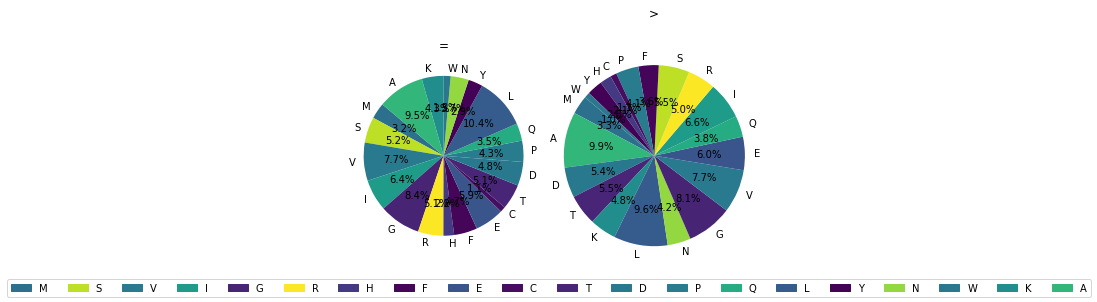

In [66]:
def parse_direction(row):
    direction = '='
    if row.reference > row['max']: direction = '>'
    elif row.reference < row['min']: direction = '<'
    return direction

fva_results_with_sequence['indirection'] = fva_results_with_sequence.apply(parse_direction, axis =1)
inrange_seq_info = fva_results_with_sequence.groupby('indirection', as_index=False)

fig, axs = plt.subplots(ncols = 2)
i=0
colors = plt.cm.viridis.colors  # Choose a colormap, e.g., tab10

# Dictionary to store COG descriptions and corresponding colors
aa_colors = {}


for inrange, seq_data in inrange_seq_info:
    seq_summary = summarize_sequence_features(seq_data.sequence)
    sizes = list(seq_summary.values())
    labels = list(seq_summary.keys())
    # Assigning colors to COG descriptions
    for label in labels:
        if not label in aa_colors.keys():
            color = random.sample(colors, 1)
            # Remove sampled colors from the original set of colors
            colors = [c for c in colors if c not in color]
            aa_colors[label] = color[0]
    # Creating the pie chart
    axs[i].pie(sizes, colors=[aa_colors[label] for label in labels],
               autopct='%1.1f%%', startangle=140, labels = labels)
    axs[i].set_title(inrange)
    i+=1
    
# Creating a legend for COG descriptions and colors
handles = [plt.Rectangle((0,0),1,1, color=aa_colors[label]) for label in aa_colors]
labels = list(aa_colors.keys())
fig.legend(handles, labels, loc='lower center', ncol = len(labels))

plt.tight_layout()
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

In [69]:
seq_summary = {}
for inrange, seq_data in inrange_seq_info:
    seq_summary[inrange] = summarize_sequence_features(seq_data.sequence)

In [70]:
for aa, frac in seq_summary['>'].items():
    if abs(frac - seq_summary['='][aa])>0.05:
        print(aa, seq_summary['='][aa], seq_summary[False][aa])

In [67]:
fva_results_with_sequence

,isinrange,min,reference,max,COG,COG description,gene_name,sequence,indirection
b0720,False,1.341553e-11,1.057477e-07,6.987255e-10,C,Energy production and conversion,gltA,MADTKAKLTLNGDTAVELDVLKGTLGQDVIDIRTLGSKGVFTFDPG...,>
b3403,False,0.000000e+00,1.126019e-07,0.000000e+00,C,Energy production and conversion,pck,NaN,>
b1479,False,0.000000e+00,9.608811e-08,0.000000e+00,C,Energy production and conversion,maeA,MEPKTKKQRSLYIPYAGPVLLEFPLLNKGSAFSMEERRNFNLLGLL...,>
b3925,False,0.000000e+00,9.675921e-08,0.000000e+00,G,Carbohydrate transport and metabolism,glpX,MRRELAIEFSRVTESAALAGYKWLGRGDKNTADGAAVNAMRIMLNQ...,>
b4232,False,0.000000e+00,9.676092e-08,0.000000e+00,G,Carbohydrate transport and metabolism,fbp,MKTLGEFIVEKQHEFSHATGELTALLSAIKLGAKIIHRDINKAGLV...,>
...,...,...,...,...,...,...,...,...,...
b2284,True,0.000000e+00,1.062763e-07,3.009661e-01,C,Energy production and conversion,nuoF,MKNIIRTPETHPLTWRLRDDKQPVWLDEYRSKNGYEGARKALTGLS...,=
b2282,True,0.000000e+00,1.106636e-07,4.118645e-01,C,Energy production and conversion,nuoH,MSWISPELIEILLTILKAVVILLVVVTCGAFMSFGERRLLGLFQNR...,=
b2286,True,0.000000e+00,1.261362e-07,2.247998e-01,C,Energy production and conversion,nuoC,MTDLTAQEPAWQTRDHLDDPVIGELRNRFGPDAFTVQATRTGVPVV...,=
b2987,False,1.412476e-10,5.725252e-08,7.356647e-09,P,Inorganic ion transport and metabolism,pitB,MLNLFVGLDIYTGLLLLLALAFVLFYEAINGFHDTANAVAAVIYTR...,>
